# [COM6513] Assignment 2: Topic Classification with a Feedforward Network


### Instructor: Nikos Aletras


The goal of this assignment is to develop a Feedforward neural network for topic classification. 



For that purpose, you will implement:

- Text processing methods for transforming raw text data into input vectors for your network  (**1 mark**)


- A Feedforward network consisting of:
    - **One-hot** input layer mapping words into an **Embedding weight matrix** (**1 mark**)
    - **One hidden layer** computing the mean embedding vector of all words in input followed by a **ReLU activation function** (**1 mark**)
    - **Output layer** with a **softmax** activation. (**1 mark**)


- The Stochastic Gradient Descent (SGD) algorithm with **back-propagation** to learn the weights of your Neural network. Your algorithm should:
    - Use (and minimise) the **Categorical Cross-entropy loss** function (**1 mark**)
    - Perform a **Forward pass** to compute intermediate outputs (**3 marks**)
    - Perform a **Backward pass** to compute gradients and update all sets of weights (**6 marks**)
    - Implement and use **Dropout** after each hidden layer for regularisation (**2 marks**)



- Discuss how did you choose hyperparameters? You can tune the learning rate (hint: choose small values), embedding size {e.g. 50, 300, 500}, the dropout rate {e.g. 0.2, 0.5} and the learning rate. Please use tables or graphs to show training and validation performance for each hyperparameter combination  (**2 marks**). 



- After training a model, plot the learning process (i.e. training and validation loss in each epoch) using a line plot and report accuracy. Does your model overfit, underfit or is about right? (**1 mark**).



- Re-train your network by using pre-trained embeddings ([GloVe](https://nlp.stanford.edu/projects/glove/)) trained on large corpora. Instead of randomly initialising the embedding weights matrix, you should initialise it with the pre-trained weights. During training, you should not update them (i.e. weight freezing) and backprop should stop before computing gradients for updating embedding weights. Report results by performing hyperparameter tuning and plotting the learning process. Do you get better performance? (**3 marks**).



- Extend you Feedforward network by adding more hidden layers (e.g. one more or two). How does it affect the performance? Note: You need to repeat hyperparameter tuning, but the number of combinations grows exponentially. Therefore, you need to choose a subset of all possible combinations (**4 marks**)


- Provide well documented and commented code describing all of your choices. In general, you are free to make decisions about text processing (e.g. punctuation, numbers, vocabulary size) and hyperparameter values. We expect to see justifications and discussion for all of your choices (**2 marks**). 



- Provide efficient solutions by using Numpy arrays when possible. Executing the whole notebook with your code should not take more than 10 minutes on any standard computer (e.g. Intel Core i5 CPU, 8 or 16GB RAM) excluding hyperparameter tuning runs and loading the pretrained vectors. You can find tips in Lab 1 (**2 marks**). 



### Data 

The data you will use for the task is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.

### Pre-trained Embeddings

You can download pre-trained GloVe embeddings trained on Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors, 2.03 GB download) from [here](http://nlp.stanford.edu/data/glove.840B.300d.zip). No need to unzip, the file is large.

### Save Memory

To save RAM, when you finish each experiment you can delete the weights of your network using `del W` followed by Python's garbage collector `gc.collect()`




### Submission Instructions

You should submit a Jupyter Notebook file (assignment2.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex`).


You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/3/library/index.html), NumPy, SciPy (excluding built-in softmax funtcions) and Pandas. You are **not allowed to use any third-party library** such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras, Pytorch etc.. You should mention if you've used Windows to write and test your code because we mostly use Unix based machines for marking (e.g. Ubuntu, MacOS). 

There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1-scores around 80\% or higher. The quality of the analysis of the results is as important as the accuracy itself. 

This assignment will be marked out of 30. It is worth 30\% of your final grade in the module.

The deadline for this assignment is **23:59 on Mon, 9 May 2022** and it needs to be submitted via Blackboard. Standard departmental penalties for lateness will be applied. We use a range of strategies to **detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index)**, including Turnitin which helps detect plagiarism. Use of unfair means would result in getting a failing grade.



In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
from time import localtime, strftime
from scipy.stats import spearmanr,pearsonr
import zipfile
import gc

# fixing random seed for reproducibility
random.seed(16269)
np.random.seed(16269)


## Transform Raw texts into training and development data

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [2]:
#import data
df_train = pd.read_csv('./data_topic/train.csv',names = ['label','text'])
df_dev = pd.read_csv('./data_topic/dev.csv',names = ['label','text'])
df_test = pd.read_csv('./data_topic/test.csv',names = ['label','text'])

In [3]:
df_train

,label,text
0,1,Reuters - Venezuelans turned out early\and in ...
1,1,Reuters - South Korean police used water canno...
2,1,Reuters - Thousands of Palestinian\prisoners i...
3,1,AFP - Sporadic gunfire and shelling took place...
4,1,AP - Dozens of Rwandan soldiers flew into Suda...
...,...,...
2395,3,"Australia #39;s dominant airline, Qantas, has ..."
2396,3,Reuters - Medtronic Inc. (MDT.N) on Wednesday\...
2397,3,SAN FRANCISCO (Reuters) - Google Inc. &lt;A H...
2398,3,"BHP Billiton, the world #39;s biggest mining c..."


In [4]:
#split whole data into content and label (in the required data type)
train_y = df_train.iloc[:,0]
train_x = df_train.iloc[:,1]
train_x = train_x.tolist()
train_y = train_y.values
test_y = df_test.iloc[:,0]
test_x = df_test.iloc[:,1]
test_x = test_x.tolist()
test_y = test_y.values
dev_y = df_dev.iloc[:,0]
dev_x = df_dev.iloc[:,1]
dev_x = dev_x.tolist()
dev_y = dev_y.values

In [5]:
#change from [1,2,3] to [0,1,2] for fitting the classification model
train_y -= 1
dev_y -= 1
test_y -= 1

In [6]:
dev_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

# Create input representations


To train your Feedforward network, you first need to obtain input representations given a vocabulary. One-hot encoding requires large memory capacity. Therefore, we will instead represent documents as lists of vocabulary indices (each word corresponds to a vocabulary index). 


## Text Pre-Processing Pipeline

To obtain a vocabulary of words. You should: 
- tokenise all texts into a list of unigrams (tip: you can re-use the functions from Assignment 1) 
- remove stop words (using the one provided or one of your preference) 
- remove unigrams appearing in less than K documents
- use the remaining to create a vocabulary of the top-N most frequent unigrams in the entire corpus.


In [7]:
#use stop words from text processing lecture last semester 
stop_words = ['a', 'able', 'about', 'above', 'according', 'accordingly', 'across','ron','con','em','9', 'actually', 'after','afterwards', 'again', 'against', 'all', 'allow', 'allows', 'almost', 'alone', 'along', 'already',
'also', 'although', 'always', 'am', 'among', 'amongst', 'an', 'and', 'another', 'any', 'anybody', 'anyhow', 'anyone', 'anything', 'anyway', 'anyways', 'anywhere', 'apart', 'appear', 'appreciate', 'appropriate', 'are', 'around', 'as', 'aside', 'ask', 'asking', 'associated', 'at', 'available', 'away', 'awfully', 'b', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'believe', 'below', 'beside', 'besides', 'best', 'better', 'between', 'beyond', 'both', 'brief', 'but', 'by', 'c', 'came', 'can', 'cannot', 'cant', 'cause', 'causes', 'certain', 'certainly', 'changes', 'clearly', 'co', 'com', 'come', 'comes', 'concerning', 'consequently', 'consider', 'considering', 'contain', 'containing', 'contains', 'corresponding', 'could', 'course', 'currently', 'd','definitely', 'described', 'despite', 'did', 'different', 'do', 'does', 'doing', 'done', 'down', 'downwards', 'during', 'e', 'each', 'edu', 'eg', 'eight', 'either', 'else', 'elsewhere', 'enough', 'entirely', 'especially', 'et', 'etc', 'even', 'ever', 'every', 'everybody', 'everyone', 'everything', 'everywhere', 'ex', 'exactly', 'example', 'except', 'f', 'far', 'few', 'fifth', 'first', 'five', 'followed', 'following', 'follows', 'for', 'former', 'formerly', 'forth', 'four', 'from', 'further', 'furthermore', 'g', 'get', 'gets', 'getting', 'given', 'gives', 'go', 'goes', 'going', 'gone', 'got', 'gotten', 'greetings', 'h', 'had', 'happens', 'hardly', 'has',
'have', 'having', 'he', 'hello', 'help', 'hence', 'her', 'here', 'hereafter', 'hereby', 'herein', 'hereupon', 'hers', 'herself', 'hi', 'him', 'himself', 'his', 'hither', 'hopefully', 'how', 'howbeit', 'however', 'i', 'ie',
'if', 'ignored', 'immediate', 'in', 'inasmuch', 'inc', 'indeed', 'indicate', 'indicated', 'indicates', 'inner', 'insofar', 'instead', 'into', 'inward', 'is', 'it', 'its', 'itself', 'j', 'just', 'k', 'keep', 'keeps', 'kept', 'know', 'knows', 'known', 'l', 'last', 'lately', 'later', 'latter', 'latterly', 'least', 'less', 'lest', 'let', 'like', 'liked', 'likely', 'little', 'look', 'looking', 'looks', 'ltd', 'm', 'mainly', 'many',
'may', 'maybe', 'me', 'mean', 'meanwhile', 'merely','might', 'more', 'moreover', 'most', 'mostly', 'much', 'must', 'my', 'myself', 'n', 'name', 'namely', 'nd','l','al','ed','la','1'
'near', 'nearly', 'necessary', 'need', 'needs', 'neither', 'never', 'nevertheless', 'new', 'next', 'nine', 'no', 'nobody','er','ad','fu','nc','ho','par','ol','pulp', 'non', 'none', 'noone', 'nor', 'normally','not', 'note', 'nothing', 'novel', 'now', 'nowhere', 'o', 'obviously', 'of', 'off', 'often', 'oh', 'ok', 'okay','ill',
'old', 'on', 'once', 'one', 'ones', 'only', 'onto', 'or', 'other', 'others', 'otherwise', 'ought', 'our', 'ours', 'ourselves', 'out', 'outside', 'over', 'overall', 'own','p', 'particular', 'particularly', 'per', 'perhaps', 'placed', 'please', 'plus', 'possible', 'presumably', 'probably', 'provides', 'q', 'que', 'quite', 'qv', 'r', 'rather', 'rd', 're', 'really', 'reasonably', 'regarding', 'regardless', 'regards', 'relatively', 'respectively', 'right', 's', 'said', 'same', 'saw', 'say', 'saying',
'says', 'second', 'secondly', 'see', 'seeing', 'seem', 'seemed', 'seeming', 'seems', 'seen', 'self', 'selves', 'sensible', 'sent', 'serious', 'seriously', 'seven', 'several', 'shall', 'she', 'should', 'since', 'six', 'so', 'some', 'somebody', 'somehow', 'someone', 'something', 'sometime', 'sometimes', 'somewhat', 'somewhere', 'soon', 'sorry', 'specified', 'specify', 'specifying', 'still', 'sub', 'such', 'sup', 'sure', 't', 'take', 'taken', 'tell', 'tends', 'th', 'than', 'thank', 'thanks', 'thanx', 'that', 'thats', 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'thence', 'there', 'thereafter', 'thereby', 'therefore', 'therein', 'theres', 'thereupon', 'these', 'they', 'think', 'third', 'this', 'thorough', 'thoroughly', 'those', 'though', 'three', 'through', 'throughout', 'thru', 'thus', 'to', 'together', 'too', 'took', 'toward', 'towards', 'tried', 'tries', 'truly', 'try', 'trying', 'twice', 'two', 'u', 'un', 'under', 'unfortunately', 'unless', 'unlikely', 'until', 'unto', 'up', 'upon', 'us', 'use', 'used',
'useful', 'uses', 'using', 'usually', 'uucp', 'v', 'value', 'various', 've', 'very', 'via', 'viz', 'vs', 'w', 'want', 'dr','isn','want','was', 'way', 'we', 'welcome', 'well', 'went', 'were','de','fi','ll','don',
'what', 'whatever', 'when', 'whence', 'whenever', 'where', 'whereafter', 'whereas', 'whereby', 'wherein', 'whereupon','wherever', 'whether', 'which', 'while', 'whither', 'who', 'whoever', 'whole', 'whom', 'whose', 'why', 'will', 'willing', 'wish', 'with', 'within', 'without', 'wonder', 'would', 'would', 'x', 'y', 'yes', 'yet', 'you', 'your', 'yours', 'yourself', 'yourselves', 'z', 'zero']


### Unigram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.


In [8]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=[], vocab=set()):
    
    tokenRE = re.compile(token_pattern)
   
    # first extract all unigrams by tokenising
    x_uni = [w for w in tokenRE.findall(str(x_raw).lower(),) if w not in stop_words]
   
    # this is to store the ngrams to be returned
    x = []
   
    if ngram_range[0]==1:
        x = x_uni
   
    # generate n-grams from the available unigrams x_uni
    ngrams = []
    for n in range(ngram_range[0], ngram_range[1]+1):
       
        # ignore unigrams
        if n==1: continue
       
        # pass a list of lists as an argument for zip
        arg_list = [x_uni]+[x_uni[i:] for i in range(1, n)]

        # extract tuples of n-grams using zip
        # for bigram this should look: list(zip(x_uni, x_uni[1:]))
        # align each item x[i] in x_uni with the next one x[i+1].
        # Note that x_uni and x_uni[1:] have different lengths
        # but zip ignores redundant elements at the end of the second list
        # Alternatively, this could be done with for loops
        x_ngram = list(zip(*arg_list))
        ngrams.append(x_ngram)
   
       
    for n in ngrams:
        for t in n:
            x.append(t)
       
    if len(vocab)>0:
        x = [w for w in x if w in vocab]
       
    return x


### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab


In [9]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b',
              min_df=0, keep_topN=0, stop_words=[]):
   
    tokenRE = re.compile(token_pattern)
   
    df = Counter()
    ngram_counts = Counter()
    vocab = set()
   
    # iterate through each raw text
    for x in X_raw:
       
        x_ngram = extract_ngrams(x, ngram_range=ngram_range, token_pattern=token_pattern, stop_words=stop_words)
       
        #update doc and ngram frequencies
        df.update(list(set(x_ngram)))
        ngram_counts.update(x_ngram)

    # obtain a vocabulary as a set.
    # Keep elements with doc frequency > minimum doc freq (min_df)
    # Note that df contains all te
    vocab = set([w for w in df if df[w]>=min_df])
   
    # keep the top N most frequent
    if keep_topN>0:
        vocab = set([w[0] for w in ngram_counts.most_common(keep_topN) if w[0] in vocab])
   
   
    return vocab, df, ngram_counts

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of unigrams:

In [10]:
#get vocab 
train_voc_set,train_df,train_ngcount = get_vocab(train_x,ngram_range = (1,1),stop_words=stop_words)
dev_voc_set,dev_df,dev_ngcount = get_vocab(dev_x,ngram_range = (1,1),stop_words=stop_words)
test_voc_set,test_df,test_ngcount = get_vocab(test_x,ngram_range = (1,1),stop_words=stop_words)

In [11]:
#train_voc_set

In [12]:
#check the data size
print(len(train_voc_set),len(train_df),len(train_ngcount))
print(len(dev_voc_set),len(dev_df),len(dev_ngcount))
print(len(test_voc_set),len(test_df),len(test_ngcount))

8596 8596 8596
1629 1629 1629
5672 5672 5672


Then, you need to create vocabulary id -> word and word -> vocabulary id dictionaries for reference:

In [13]:
#make two dict for id word and word id
voc_id2word = enumerate(train_voc_set)
voc_id2word = dict(voc_id2word)
word2voc_id = {value:key for key,value in voc_id2word.items()}

In [14]:
word2voc_id

{'living': 0,
 'inspiration': 1,
 'plotters': 2,
 'grow': 3,
 'brings': 4,
 'engages': 5,
 'quarter': 6,
 'imminent': 7,
 'nationals': 8,
 'honor': 9,
 'air': 10,
 'possibly': 11,
 'dimitris': 12,
 'filings': 13,
 'expectation': 14,
 'lost': 15,
 'breezy': 16,
 'primary': 17,
 'inter': 18,
 'southwestern': 19,
 'stun': 20,
 'enact': 21,
 'heat': 22,
 'ashburn': 23,
 'competitor': 24,
 'supposed': 25,
 'opens': 26,
 'balls': 27,
 'zalmay': 28,
 'masterminded': 29,
 'devices': 30,
 'resume': 31,
 'connecticut': 32,
 'kathmandu': 33,
 'testifying': 34,
 'fraud': 35,
 'secret': 36,
 'polo': 37,
 'flowing': 38,
 'americans': 39,
 'earn': 40,
 'page': 41,
 'aj': 42,
 'fatal': 43,
 'direct': 44,
 'absolute': 45,
 'outlawed': 46,
 'zeitoun': 47,
 'survey': 48,
 'sasebo': 49,
 'weaken': 50,
 'tortuous': 51,
 'wear': 52,
 'lore': 53,
 'rebuilding': 54,
 'downfall': 55,
 'successor': 56,
 'succumbed': 57,
 'iwf': 58,
 'resignation': 59,
 'trader': 60,
 'committee': 61,
 'arrived': 62,
 'hearted':

### Convert the list of unigrams  into a list of vocabulary indices

Storing actual one-hot vectors into memory for all words in the entire data set is prohibitive. Instead, we will store word indices in the vocabulary and look-up the weight matrix. This is equivalent of doing a dot product between an one-hot vector and the weight matrix. 

First, represent documents in train, dev and test sets as lists of words in the vocabulary:

In [15]:
#get the unigram data 
uni_train_x = [extract_ngrams(train_x[i],ngram_range=(1,1), stop_words= stop_words) for i in range(len(train_x))]
uni_dev_x = [extract_ngrams(dev_x[i],ngram_range=(1,1), stop_words= stop_words) for i in range(len(dev_x))]
uni_test_x = [extract_ngrams(test_x[i],ngram_range=(1,1), stop_words= stop_words) for i in range(len(test_x))]

In [16]:
#uni_train_x[0]

Then convert them into lists of indices in the vocabulary:

In [17]:
#covert data into indices
train_indices_x = list(range(len(uni_train_x)))
dev_indices_x = list(range(len(uni_dev_x)))
test_indices_x = list(range(len(uni_test_x)))
for i in range(len(uni_train_x)):
    temp1 = []
    for j in uni_train_x[i]:
        if j in word2voc_id.keys():
            temp1.append(word2voc_id[j])
    train_indices_x[i] = temp1
for i in range(len(uni_dev_x)):
    temp2 = []
    for j in uni_dev_x[i]:
        if j in word2voc_id.keys():
            temp2.append(word2voc_id[j])
    dev_indices_x[i] = temp2
for i in range(len(uni_test_x)):
    temp3 = []
    for j in uni_test_x[i]:
        if j in word2voc_id.keys():
            temp3.append(word2voc_id[j])
    test_indices_x[i] = temp3

In [18]:
train_indices_x[0]

[7949,
 176,
 7922,
 4247,
 3639,
 2828,
 6569,
 1600,
 423,
 4722,
 5400,
 6736,
 6270,
 4796,
 8363,
 5832,
 1013,
 429,
 3586,
 1276,
 6170]

Put the labels `Y` for train, dev and test sets into arrays: 

In [19]:
dev_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

# Network Architecture

Your network should pass each word index into its corresponding embedding by looking-up on the embedding matrix and then compute the first hidden layer $\mathbf{h}_1$:

$$\mathbf{h}_1 = \frac{1}{|x|}\sum_i W^e_i, i \in x$$

where $|x|$ is the number of words in the document and $W^e$ is an embedding matrix $|V|\times d$, $|V|$ is the size of the vocabulary and $d$ the embedding size.

Then $\mathbf{h}_1$ should be passed through a ReLU activation function:

$$\mathbf{a}_1 = relu(\mathbf{h}_1)$$

Finally the hidden layer is passed to the output layer:


$$\mathbf{y} = \text{softmax}(\mathbf{a}_1W) $$ 
where $W$ is a matrix $d \times |{\cal Y}|$, $|{\cal Y}|$ is the number of classes.

During training, $\mathbf{a}_1$ should be multiplied with a dropout mask vector (elementwise) for regularisation before it is passed to the output layer.

You can extend to a deeper architecture by passing a hidden layer to another one:

$$\mathbf{h_i} = \mathbf{a}_{i-1}W_i $$

$$\mathbf{a_i} = relu(\mathbf{h_i}) $$



# Network Training

First we need to define the parameters of our network by initiliasing the weight matrices. For that purpose, you should implement the `network_weights` function that takes as input:

- `vocab_size`: the size of the vocabulary
- `embedding_dim`: the size of the word embeddings
- `hidden_dim`: a list of the sizes of any subsequent hidden layers. Empty if there are no hidden layers between the average embedding and the output layer 
- `num_classes`: the number of the classes for the output layer

and returns:

- `W`: a dictionary mapping from layer index (e.g. 0 for the embedding matrix) to the corresponding weight matrix initialised with small random numbers (hint: use numpy.random.uniform with from -0.1 to 0.1)

Make sure that the dimensionality of each weight matrix is compatible with the previous and next weight matrix, otherwise you won't be able to perform forward and backward passes. Consider also using np.float32 precision to save memory.

In [20]:
def network_weights(vocab_size=1000, embedding_dim=300, 
                    hidden_dim=[], num_classes=3, init_val = 0.5):
    np.random.seed(16269)
    #get the size of each variable and use np.random.uniform to assign each layer size
    dim_list = []
    dim_list.append(vocab_size)
    dim_list.append(embedding_dim)
    dim_list.extend(hidden_dim)
    dim_list.append(num_classes)
    
    W={}
    for i in range(len(dim_list)-1): 
        W[i] = np.random.uniform(-init_val,init_val,(dim_list[i],dim_list[i+1])).astype('float32')
    return W
    

In [21]:
W = network_weights(vocab_size=5,embedding_dim=10,hidden_dim=[10,2], num_classes=2)

print('W_emb:', W[0].shape)
print('W_out:', W[1].shape)


W_emb: (5, 10)
W_out: (10, 10)


In [22]:
#check the network_weights work or not 
W = network_weights(vocab_size=3,embedding_dim=4,hidden_dim=[3,4], num_classes=2)
W

{0: array([[ 0.12224471, -0.0794624 , -0.23009355,  0.29406023],
        [-0.46997094,  0.12204431, -0.0749153 ,  0.37384233],
        [-0.3974818 ,  0.3035981 ,  0.46178967, -0.43050396]],
       dtype=float32),
 1: array([[-0.31256202, -0.42996365, -0.2553189 ],
        [-0.28818667, -0.15275556, -0.22158206],
        [-0.20424126,  0.4211786 , -0.4858057 ],
        [ 0.45516163,  0.22709407, -0.19921613]], dtype=float32),
 2: array([[-0.02515792,  0.37151852,  0.32920408,  0.3873491 ],
        [ 0.23128773, -0.08528457,  0.22343004,  0.44983786],
        [-0.23429091,  0.00418209,  0.3896187 ,  0.01652054]],
       dtype=float32),
 3: array([[-0.40125608, -0.16001858],
        [ 0.30069476,  0.21305238],
        [-0.4713758 , -0.10194607],
        [ 0.02704137, -0.39511573]], dtype=float32)}

Then you need to develop a `softmax` function (same as in Assignment 1) to be used in the output layer. 

It takes as input `z` (array of real numbers) and returns `sig` (the softmax of `z`)



In [23]:
def softmax(z):
    soft = np.exp(z- np.max(z))
    soft = soft / soft.sum()
    return soft

Now you need to implement the categorical cross entropy loss by slightly modifying the function from Assignment 1 to depend only on the true label `y` and the class probabilities vector `y_preds`:


In [24]:
def categorical_loss(y, y_preds):
    #print(y_preds)
    y_max = max(y_preds)
    l = (-y) * np.log(y_max)
    return l

Then, implement the `relu` function to introduce non-linearity after each hidden layer of your network 
(during the forward pass): 

$$relu(z_i)= max(z_i,0)$$

and the `relu_derivative` function to compute its derivative (used in the backward pass):

  
  relu_derivative($z_i$)=0, if $z_i$<=0, 1 otherwise.
  


Note that both functions take as input a vector $z$ 

Hint use .copy() to avoid in place changes in array z

In [25]:
def relu(z):
    a = np.maximum(z,0)
    return a
    
def relu_derivative(z):
    z_cp = z.copy()
    z_cp[z_cp<=0] =0
    z_cp[z_cp>0] =1
    return z_cp

During training you should also apply a dropout mask element-wise after the activation function (i.e. vector of ones with a random percentage set to zero). The `dropout_mask` function takes as input:

- `size`: the size of the vector that we want to apply dropout
- `dropout_rate`: the percentage of elements that will be randomly set to zeros

and returns:

- `dropout_vec`: a vector with binary values (0 or 1)

In [26]:
def dropout_mask(size, dropout_rate):
    np.random.seed(16269)
    num = size*dropout_rate
    dropout_vec = np.ones(size)
    dropout_ind = np.random.choice(np.arange(size),replace = False,size = int(num))
    dropout_vec[dropout_ind] = 0 
    return dropout_vec

In [27]:
print(dropout_mask(10, 0.2))
print(dropout_mask(10, 0.2))

[0. 1. 1. 1. 1. 1. 1. 0. 1. 1.]
[0. 1. 1. 1. 1. 1. 1. 0. 1. 1.]


Now you need to implement the `forward_pass` function that passes the input x through the network up to the output layer for computing the probability for each class using the weight matrices in `W`. The ReLU activation function should be applied on each hidden layer. 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `dropout_rate`: the dropout rate that is used to generate a random dropout mask vector applied after each hidden layer for regularisation.

and returns:

- `out_vals`: a dictionary of output values from each layer: h (the vector before the activation function), a (the resulting vector after passing h from the activation function), its dropout mask vector; and the prediction vector (probability for each class) from the output layer.

In [28]:
def forward_pass(x, W, dropout_rate=0.2): 
    
    out_vals = {}
    h_vecs = []
    a_vecs = []
    dropout_vecs = []
    #count the weight of first layer, do relu and dropout function
    w_emb = [W[0][index] for index in x]
    h = np.mean(np.array(w_emb),axis=0)
    a = relu(h)
    drop_vec = dropout_mask(len(a), dropout_rate)
    output = a*drop_vec
    h_vecs.append(h)
    a_vecs.append(a)
    dropout_vecs.append(drop_vec)
    #other layers
    for i in range(1,len(W)-1):
        h = np.dot(output,W[i])
        a = relu(h)
        drop_vec = dropout_mask(len(a), dropout_rate)
        output = a*drop_vec
        h_vecs.append(h)
        a_vecs.append(a)
        dropout_vecs.append(drop_vec)
    
    y_pre = softmax(np.dot(output,W[len(W)-1]))
    
    out_vals['h'] = h_vecs
    out_vals['a'] = a_vecs
    out_vals['dropout_vecs'] = dropout_vecs
    out_vals['y'] = y_pre
    
    return out_vals
    

In [29]:
#check is forward_pass function working or not
W = network_weights(vocab_size=100,embedding_dim=20,hidden_dim=[4,2], num_classes=2)

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

print(forward_pass([5,0], W, dropout_rate=0.5))

Shape W0 (100, 20)
Shape W1 (20, 4)
Shape W2 (4, 2)
Shape W3 (2, 2)
{'h': [array([ 0.17688254, -0.00454105,  0.05746456, -0.00638478, -0.13021453,
       -0.04556508, -0.02224372,  0.05884917, -0.2432979 , -0.04557189,
        0.06403284, -0.29234985, -0.3149953 , -0.27194694, -0.1704622 ,
        0.06597526, -0.08525288, -0.20908287, -0.18800098,  0.15818825],
      dtype=float32), array([ 0.00223933,  0.03659521, -0.02797977, -0.03967538]), array([0.00765979, 0.00364189])], 'a': [array([0.17688254, 0.        , 0.05746456, 0.        , 0.        ,
       0.        , 0.        , 0.05884917, 0.        , 0.        ,
       0.06403284, 0.        , 0.        , 0.        , 0.        ,
       0.06597526, 0.        , 0.        , 0.        , 0.15818825],
      dtype=float32), array([0.00223933, 0.03659521, 0.        , 0.        ]), array([0.00765979, 0.00364189])], 'dropout_vecs': [array([1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1.,
       1., 0., 1.]), array([0., 1., 1.,

The `backward_pass` function computes the gradients and updates the weights for each matrix in the network from the output to the input. It takes as input 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `y`: the true label
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `out_vals`: a dictionary of output values from a forward pass.
- `learning_rate`: the learning rate for updating the weights.
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated.

and returns:

- `W`: the updated weights of the network.

Hint: the gradients on the output layer are similar to the multiclass logistic regression.

In [30]:
def backward_pass(x, y, W, out_vals, lr=0.001, freeze_emb=True):
    
    #calculate gradient 
    grad = out_vals['y'] - (np.arange(len(out_vals['y'])) == y)

    # calculate weights
    out_layer_input = out_vals['a'][-1] * out_vals['dropout_vecs'][-1]
    grad_on_wt = np.outer(grad, out_layer_input)
    grad_on_wt = grad_on_wt.T
    grad = grad.dot(W[len(W)-1].T)
    
    # update weight
    W[len(W)-1] -= lr * grad_on_wt

    # Update each hidden layer
    for i in range(len(W) - 2, 1, -1):
        grad *= relu_derivative(out_vals['h'][i])

        # calculate weights
        layer_input = out_vals['a'][i - 1] * out_vals['dropout_vecs'][i - 1]
        grad_on_wt = np.outer(grad, layer_input)
        grad_on_wt = grad_on_wt.T
        grad = grad.dot(W[i].T)

        # update weight
        W[i] -= lr * grad_on_wt

    # Update weights of the initial layer
    if not freeze_emb:
        grad *= relu_derivative(out_vals['h'][0])
        W[0][x] -= lr * grad
    
            
    return W




Finally you need to modify SGD to support back-propagation by using the `forward_pass` and `backward_pass` functions.

The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `W`: the weights of the network (dictionary)
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `dropout`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated (to be used by the backward pass function).
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [31]:
import time
def SGD(X_tr, Y_tr, W, X_dev=[], Y_dev=[], lr=0.001, 
        dropout=0.2, epochs=5, tolerance=0.001, freeze_emb=False, 
        print_progress=True):
    #np.random.seed(16269)
    training_loss_history = []
    validation_loss_history = []

    train_docs = list(zip(X_tr, Y_tr))
    dev_docs = list(zip(X_dev,Y_dev))
                        
    for i in range(0,epochs):
        #Randomise the order of each epoch
        np.random.seed(i)
        new_X_tr = np.random.permutation(X_tr)
        np.random.seed(i)
        new_Y_tr = np.random.permutation(Y_tr)
        new_train_docs = list(zip(new_X_tr,new_Y_tr))
        
        for x_i, y_i in new_train_docs:
            #fo = time.time()
            out_vals = forward_pass(x_i, W, dropout)
            #fo_end = time.time()
            #ba = time.time()
            W = backward_pass(x_i, y_i, W, out_vals, lr, freeze_emb)
            #ba_end = time.time()
            #print(ba_end - ba, fo_end - fo)
        #train loss
        temp_loss_tr = [categorical_loss(y_i, forward_pass(x_i, W, dropout)['y']) for x_i, y_i in train_docs]
        cur_loss_tr = np.mean(temp_loss_tr)

        # Validation loss
        temp_loss_dev = [categorical_loss(y_i, forward_pass(x_i, W, dropout)['y']) for x_i, y_i in dev_docs]
        cur_loss_dev = np.mean(temp_loss_dev)

        training_loss_history.append(cur_loss_tr)
        validation_loss_history.append(cur_loss_dev)

        if print_progress:
            print(f'Epoch: {i} | Train loss: {cur_loss_tr} | Dev loss: {cur_loss_dev}')
    
    return W, training_loss_history, validation_loss_history

In [32]:
#set parameter manually just for checking model work
W = network_weights(vocab_size=len(train_voc_set),embedding_dim=300,hidden_dim=[], num_classes=3)

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

W, loss_tr, dev_loss = SGD(train_indices_x, Y_tr=train_y,
                            W=W,
                            X_dev=dev_indices_x, 
                            Y_dev=dev_y,
                            lr=0.01, 
                            dropout=0.4,
                            freeze_emb=False,
                            tolerance=0.0001,
                            epochs=40)

Shape W0 (8596, 300)
Shape W1 (300, 3)


C:\Users\88690\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch: 0 | Train loss: 0.6681947304196671 | Dev loss: 0.8068374695282586
Epoch: 1 | Train loss: 0.44509913873910517 | Dev loss: 0.6297523470086293
Epoch: 2 | Train loss: 0.31699595653408236 | Dev loss: 0.5035460339326222
Epoch: 3 | Train loss: 0.24290354786902904 | Dev loss: 0.4219174278207625
Epoch: 4 | Train loss: 0.19047502413889444 | Dev loss: 0.3627505733285442
Epoch: 5 | Train loss: 0.15721425389561267 | Dev loss: 0.32374103633971346
Epoch: 6 | Train loss: 0.12585286755154437 | Dev loss: 0.2879494428522525
Epoch: 7 | Train loss: 0.10656964027177272 | Dev loss: 0.26648152135471004
Epoch: 8 | Train loss: 0.09262765419642288 | Dev loss: 0.25121352515915724
Epoch: 9 | Train loss: 0.07665863913074862 | Dev loss: 0.2345179632192439
Epoch: 10 | Train loss: 0.06878163681034649 | Dev loss: 0.2257769212978331
Epoch: 11 | Train loss: 0.05959829058257321 | Dev loss: 0.2143477337297253
Epoch: 12 | Train loss: 0.051971081974802914 | Dev loss: 0.20416023054038523
Epoch: 13 | Train loss: 0.04634

Now you are ready to train and evaluate your neural net. First, you need to define your network using the `network_weights` function followed by SGD with backprop:

Plot the learning process:

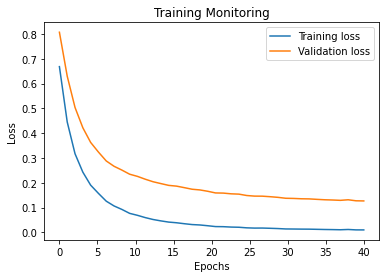

In [33]:
x = np.linspace(0,len(loss_tr),len(loss_tr))
y1, y2 = loss_tr, dev_loss
 
plt.plot(x, y1,label='Training loss')
plt.plot(x, y2, label='Validation loss')
 
plt.title('Training Monitoring')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend() 
plt.show()

According to the graph, it is neither overfitting nor underfitting. It could train more times to get the higher accuracy probably.

Compute accuracy, precision, recall and F1-Score:

In [34]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) 
            for x,y in zip(test_indices_x,test_y)]

print('Accuracy:', accuracy_score(test_y,preds_te))
print('Precision:', precision_score(test_y,preds_te,average='macro'))
print('Recall:', recall_score(test_y,preds_te,average='macro'))
print('F1-Score:', f1_score(test_y,preds_te,average='macro'))

Accuracy: 0.8611111111111112
Precision: 0.8627965786817375
Recall: 0.861111111111111
F1-Score: 0.8607497524117416


### Discuss how did you choose model hyperparameters ? 

In [35]:
# Firstly We should establish the list to select the parameters
from prettytable import PrettyTable
dim_choice=[100,200,300]
lr_rate = [0.1,0.01,0.05]
dropout_rate = [0.2,0.4,0.5]
hyper_result = 0.0
test_result = 0.0
result = list()
dim_his = []
lr_his = []
drop_his =[]
for dim in range(len(dim_choice)):
    for lr in range(len(lr_rate)):
        for drop in range(len(dropout_rate)):
            W = network_weights(vocab_size=len(train_voc_set),embedding_dim=dim_choice[dim],hidden_dim=[],
                                num_classes=3, init_val = 0.1)
            W, loss_tr, dev_loss = SGD(train_indices_x, Y_tr=train_y, W=W, X_dev=dev_indices_x, Y_dev=dev_y, lr=lr_rate[lr], 
                            dropout=dropout_rate[drop],
                            freeze_emb=False,
                            tolerance=0.0001,
                            print_progress = False,
                            epochs=40)
            
            preds_dev = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) for x,y in zip(dev_indices_x,dev_y)]
            val_acc = accuracy_score(dev_y,preds_dev)
            hyper_result = val_acc
            
            dim_his.append(dim_choice[dim])
            lr_his.append(lr_rate[lr])
            drop_his.append(dropout_rate[drop])
            result.append(hyper_result)
            ind = result.index(max(result))
            #print(hyper_result,dim_choice[dim],lr_rate[lr],dropout_rate[drop])
print(max(result),dim_his[ind],lr_his[ind],drop_his[ind])

            

C:\Users\88690\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
C:\Users\88690\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' whe

C:\Users\88690\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
C:\Users\88690\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' whe

C:\Users\88690\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
C:\Users\88690\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' whe

0.9066666666666666 100 0.01 0.2


In [36]:
#print the table of all combinations of parameters
average_Table = PrettyTable(["Accuracy", "embedding_dim", "lr_rate", "dropout_rate"])
for i in range(len(dim_his)):
    average_Table.add_row([result[i],dim_his[i],lr_his[i],drop_his[i]])
print(average_Table)

+--------------------+---------------+---------+--------------+
|      Accuracy      | embedding_dim | lr_rate | dropout_rate |
+--------------------+---------------+---------+--------------+
|        0.86        |      100      |   0.1   |     0.2      |
| 0.8733333333333333 |      100      |   0.1   |     0.4      |
| 0.8666666666666667 |      100      |   0.1   |     0.5      |
| 0.9066666666666666 |      100      |   0.01  |     0.2      |
| 0.9066666666666666 |      100      |   0.01  |     0.4      |
|        0.9         |      100      |   0.01  |     0.5      |
|        0.88        |      100      |   0.05  |     0.2      |
|        0.88        |      100      |   0.05  |     0.4      |
|        0.88        |      100      |   0.05  |     0.5      |
| 0.8666666666666667 |      200      |   0.1   |     0.2      |
| 0.8666666666666667 |      200      |   0.1   |     0.4      |
| 0.8666666666666667 |      200      |   0.1   |     0.5      |
|        0.9         |      200      |  

In [37]:
#use best parameters to train model
W = network_weights(vocab_size=len(train_voc_set),embedding_dim=dim_his[ind],hidden_dim=[], num_classes=3)

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

W, loss_tr, dev_loss = SGD(train_indices_x, Y_tr=train_y,
                            W=W,
                            X_dev=dev_indices_x, 
                            Y_dev=dev_y,
                            lr=lr_his[ind], 
                            dropout=drop_his[ind],
                            freeze_emb=False,
                            tolerance=0.0001,
                            epochs=40)

Shape W0 (8596, 100)
Shape W1 (100, 3)


C:\Users\88690\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch: 0 | Train loss: 0.833613623346814 | Dev loss: 0.9172314271345692
Epoch: 1 | Train loss: 0.5512914197943662 | Dev loss: 0.7322137658770415
Epoch: 2 | Train loss: 0.3824599376884296 | Dev loss: 0.579509193229953
Epoch: 3 | Train loss: 0.2846680887232459 | Dev loss: 0.4690013294506205
Epoch: 4 | Train loss: 0.2195480016411855 | Dev loss: 0.39438316735393014
Epoch: 5 | Train loss: 0.1800823835782518 | Dev loss: 0.3478466127166421
Epoch: 6 | Train loss: 0.14267929922263262 | Dev loss: 0.3075578702753906
Epoch: 7 | Train loss: 0.12103407477957144 | Dev loss: 0.28249562351898727
Epoch: 8 | Train loss: 0.10464657462048903 | Dev loss: 0.2623317791979432
Epoch: 9 | Train loss: 0.08693565806233489 | Dev loss: 0.23934244895613654
Epoch: 10 | Train loss: 0.07791770831683326 | Dev loss: 0.2288314943679956
Epoch: 11 | Train loss: 0.06790316808552149 | Dev loss: 0.21547700436962772
Epoch: 12 | Train loss: 0.05872766716197998 | Dev loss: 0.20271613034489167
Epoch: 13 | Train loss: 0.052376274144

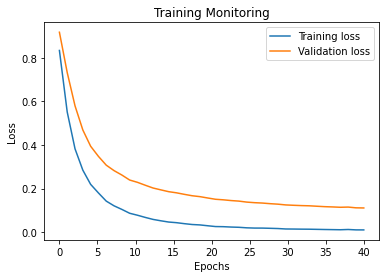

In [38]:
#plot the training loss and val loss with using best parameters
x = np.linspace(0,len(loss_tr),len(loss_tr))
y1, y2 = loss_tr, dev_loss
 
plt.plot(x, y1,label='Training loss')
plt.plot(x, y2, label='Validation loss')
 
plt.title('Training Monitoring')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend() 
plt.show()

This model is well, neither overfitting nor underfitting. Could increase epochs to train more times

In [39]:
#print the evaluation
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) 
            for x,y in zip(test_indices_x,test_y)]

print('Accuracy:', accuracy_score(test_y,preds_te))
print('Precision:', precision_score(test_y,preds_te,average='macro'))
print('Recall:', recall_score(test_y,preds_te,average='macro'))
print('F1-Score:', f1_score(test_y,preds_te,average='macro'))

Accuracy: 0.8588888888888889
Precision: 0.8619866910203213
Recall: 0.8588888888888889
F1-Score: 0.8585911905628026


We could find out that accuracy is a little bit lower than the previous one which the parameters chosen randomly. The reason is that there are many same accuracy when we use validation to find the best parameters, and we choose randomly from one of the sets of the parameters. 

# Use Pre-trained Embeddings

Now re-train the network using GloVe pre-trained embeddings. You need to modify the `backward_pass` function above to stop computing gradients and updating weights of the embedding matrix.

Use the function below to obtain the embedding martix for your vocabulary. Generally, that should work without any problem. If you get errors, you can modify it.

In [40]:
def get_glove_embeddings(f_zip, f_txt, word2id, emb_size=300):
    
    w_emb = np.zeros((len(word2id), emb_size))
    
    with zipfile.ZipFile(f_zip) as z:
        with z.open(f_txt) as f:
            for line in f:
                line = line.decode('utf-8')
                word = line.split()[0]
                     
                if word in train_voc_set:
                    emb = np.array(line.strip('\n').split()[1:]).astype(np.float32)
                    w_emb[word2id[word]] +=emb
    return w_emb

In [41]:
w_glove = get_glove_embeddings("glove.840B.300d.zip","glove.840B.300d.txt",word2voc_id)

First, initialise the weights of your network using the `network_weights` function. Second, replace the weigths of the embedding matrix with `w_glove`. Finally, train the network by freezing the embedding weights: 

In [42]:
W = network_weights(vocab_size=len(train_voc_set),embedding_dim=300,hidden_dim=[], num_classes=3, init_val = 0.5)

W[0] = w_glove

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

W, loss_tr, dev_loss = SGD(train_indices_x, Y_tr=train_y,
                            W=W,
                            X_dev=dev_indices_x, 
                            Y_dev=dev_y,
                            lr=0.001, 
                            dropout=0.4,
                            freeze_emb=True,
                            tolerance=0.0001,
                            epochs=40)

Shape W0 (8596, 300)
Shape W1 (300, 3)


C:\Users\88690\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch: 0 | Train loss: 0.9046048299881092 | Dev loss: 0.8721254910692425
Epoch: 1 | Train loss: 0.8862225808382912 | Dev loss: 0.855000323019056
Epoch: 2 | Train loss: 0.8624540794587242 | Dev loss: 0.8358953980042821
Epoch: 3 | Train loss: 0.8272456805670378 | Dev loss: 0.8000549095154829
Epoch: 4 | Train loss: 0.7997430045066902 | Dev loss: 0.7785728351115514
Epoch: 5 | Train loss: 0.7692634053738563 | Dev loss: 0.7522427314756711
Epoch: 6 | Train loss: 0.7313739775435604 | Dev loss: 0.7142393658895781
Epoch: 7 | Train loss: 0.7004890602177151 | Dev loss: 0.6866705619824497
Epoch: 8 | Train loss: 0.6792048702656869 | Dev loss: 0.6665691649869395
Epoch: 9 | Train loss: 0.6528442550999817 | Dev loss: 0.6440841954963159
Epoch: 10 | Train loss: 0.6391529304793625 | Dev loss: 0.632417938097807
Epoch: 11 | Train loss: 0.6058533596235515 | Dev loss: 0.6006359834723779
Epoch: 12 | Train loss: 0.590246720274034 | Dev loss: 0.5873136111516857
Epoch: 13 | Train loss: 0.5755612689392734 | Dev lo

In [43]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) 
            for x,y in zip(test_indices_x,test_y)]

print('Accuracy:', accuracy_score(test_y,preds_te))
print('Precision:', precision_score(test_y,preds_te,average='macro'))
print('Recall:', recall_score(test_y,preds_te,average='macro'))
print('F1-Score:', f1_score(test_y,preds_te,average='macro'))

Accuracy: 0.8722222222222222
Precision: 0.876346747104667
Recall: 0.8722222222222222
F1-Score: 0.8722686884733996


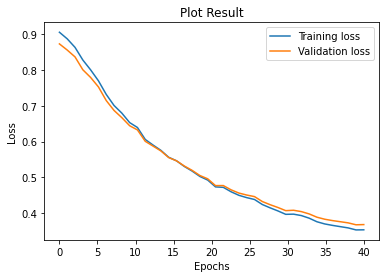

In [44]:
# Now we could plot result of the training 
x = np.linspace(0,len(loss_tr),len(loss_tr))
y1, y2 = loss_tr, dev_loss

plt.plot(x, y1,label='Training loss')
plt.plot(x, y2, label='Validation loss')
 
plt.title('Plot Result')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend() 
plt.show()

Two loss lines are quire close, it a little bit overfitting. Guessing the reason is we choose parameters manually. Below, we will use validation set to find out the best set of parameters.

### Discuss how did you choose model hyperparameters ? 

In [45]:
from prettytable import PrettyTable
lr_rate = [0.01,0.001,0.003]
dropout_rate = [0.2,0.4,0.5]
hyper_result = 0.0
test_result = 0.0
result = list()
lr_his = []
drop_his =[]
for lr in range(len(lr_rate)):
    for drop in range(len(dropout_rate)):
        W = network_weights(vocab_size=len(train_voc_set),embedding_dim=300,hidden_dim=[],
                            num_classes=3, init_val = 0.1)
        W[0] = w_glove

        W, loss_tr, dev_loss = SGD(train_indices_x, Y_tr=train_y, W=W, X_dev=dev_indices_x, Y_dev=dev_y, lr=lr_rate[lr], 
                        dropout=dropout_rate[drop],
                        freeze_emb=True,
                        tolerance=0.0001,
                        print_progress = False,
                        epochs=40)

        preds_dev = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) for x,y in zip(dev_indices_x,dev_y)]
        val_acc = accuracy_score(dev_y,preds_dev)
        hyper_result = val_acc

        lr_his.append(lr_rate[lr])
        drop_his.append(dropout_rate[drop])
        result.append(hyper_result)
        ind = result.index(max(result))
        #print(hyper_result,dim_choice[dim],lr_rate[lr],dropout_rate[drop])
print(max(result),lr_his[ind],drop_his[ind])

C:\Users\88690\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
C:\Users\88690\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' whe

0.9466666666666667 0.01 0.2


In [46]:
emb_Table = PrettyTable(["Accuracy", "lr_rate", "dropout_rate"])
for i in range(len(result)):
    emb_Table.add_row([result[i],lr_his[i],drop_his[i]])
print(emb_Table)

+--------------------+---------+--------------+
|      Accuracy      | lr_rate | dropout_rate |
+--------------------+---------+--------------+
| 0.9466666666666667 |   0.01  |     0.2      |
|        0.94        |   0.01  |     0.4      |
| 0.9333333333333333 |   0.01  |     0.5      |
| 0.9266666666666666 |  0.001  |     0.2      |
|        0.92        |  0.001  |     0.4      |
| 0.9066666666666666 |  0.001  |     0.5      |
| 0.9466666666666667 |  0.003  |     0.2      |
| 0.9466666666666667 |  0.003  |     0.4      |
|        0.94        |  0.003  |     0.5      |
+--------------------+---------+--------------+


In [47]:
#use best parameters to train model
W = network_weights(vocab_size=len(train_voc_set),embedding_dim=300,hidden_dim=[], num_classes=3)

W[0] = w_glove

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

W, loss_tr, dev_loss = SGD(train_indices_x, Y_tr=train_y,
                            W=W,
                            X_dev=dev_indices_x, 
                            Y_dev=dev_y,
                            lr=lr_his[ind], 
                            dropout=drop_his[ind],
                            freeze_emb=True,
                            tolerance=0.0001,
                            epochs=40)

Shape W0 (8596, 300)
Shape W1 (300, 3)


C:\Users\88690\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch: 0 | Train loss: 0.4915844998947296 | Dev loss: 0.5006449779018523
Epoch: 1 | Train loss: 0.425798128058617 | Dev loss: 0.4398207884422205
Epoch: 2 | Train loss: 0.34044985980640463 | Dev loss: 0.35193580675661307
Epoch: 3 | Train loss: 0.27817656749917985 | Dev loss: 0.2833111646703187
Epoch: 4 | Train loss: 0.26329895506308293 | Dev loss: 0.26618851719533737
Epoch: 5 | Train loss: 0.2716252634384927 | Dev loss: 0.2801517336387839
Epoch: 6 | Train loss: 0.20950764711832118 | Dev loss: 0.20272894841487152
Epoch: 7 | Train loss: 0.20872763504996394 | Dev loss: 0.2029238088381039
Epoch: 8 | Train loss: 0.21554166223591859 | Dev loss: 0.2132849867467142
Epoch: 9 | Train loss: 0.19456215527200907 | Dev loss: 0.1849638040180108
Epoch: 10 | Train loss: 0.20628009684220341 | Dev loss: 0.20432800945717466
Epoch: 11 | Train loss: 0.1869243528532071 | Dev loss: 0.17812913314995035
Epoch: 12 | Train loss: 0.18895422474586085 | Dev loss: 0.18307952897162702
Epoch: 13 | Train loss: 0.18770031

In [48]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) 
            for x,y in zip(test_indices_x,test_y)]

print('Accuracy:', accuracy_score(test_y,preds_te))
print('Precision:', precision_score(test_y,preds_te,average='macro'))
print('Recall:', recall_score(test_y,preds_te,average='macro'))
print('F1-Score:', f1_score(test_y,preds_te,average='macro'))

Accuracy: 0.8866666666666667
Precision: 0.887098394913521
Recall: 0.8866666666666667
F1-Score: 0.8868245713460235


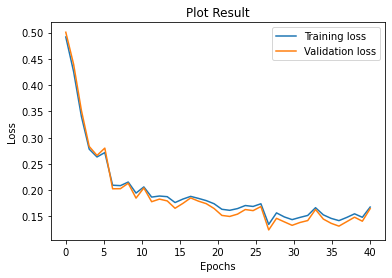

In [49]:
# Now we could plot result of the training 
x = np.linspace(0,len(loss_tr),len(loss_tr))
y1, y2 = loss_tr, dev_loss

plt.plot(x, y1,label='Training loss')
plt.plot(x, y2, label='Validation loss')
 
plt.title('Plot Result')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend() 
plt.show()

# Extend to support deeper architectures 

Extend the network to support back-propagation for more hidden layers. You need to modify the `backward_pass` function above to compute gradients and update the weights between intermediate hidden layers. Finally, train and evaluate a network with a deeper architecture. Do deeper architectures increase performance?

In [85]:
W = network_weights(vocab_size=len(train_voc_set),embedding_dim=300,hidden_dim=[200],
                            num_classes=3, init_val=0.5)

W[0] = w_glove
for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

Shape W0 (8596, 300)
Shape W1 (300, 200)
Shape W2 (200, 3)


In [86]:
W, loss_tr, dev_loss = SGD(train_indices_x, Y_tr=train_y,
                W=W,
                X_dev=dev_indices_x, 
                Y_dev=dev_y,
                lr=0.001, 
                dropout=0.4,
                freeze_emb=True,
                tolerance=0.00001,
                print_progress = True,
                epochs=60)

C:\Users\88690\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch: 0 | Train loss: 0.7044262499909549 | Dev loss: 0.7248974293344094
Epoch: 1 | Train loss: 0.6494628870045648 | Dev loss: 0.6723665842687003
Epoch: 2 | Train loss: 0.5676491042071271 | Dev loss: 0.5892675367600743
Epoch: 3 | Train loss: 0.5002353696780804 | Dev loss: 0.5155122825719176
Epoch: 4 | Train loss: 0.4647608412556802 | Dev loss: 0.4845341291578283
Epoch: 5 | Train loss: 0.4410530558703139 | Dev loss: 0.4620187394706985
Epoch: 6 | Train loss: 0.37547139420144565 | Dev loss: 0.378926368245107
Epoch: 7 | Train loss: 0.3619668623850109 | Dev loss: 0.3702339662514221
Epoch: 8 | Train loss: 0.3639939539717139 | Dev loss: 0.3797381406683233
Epoch: 9 | Train loss: 0.34038515968769045 | Dev loss: 0.35232554613075734
Epoch: 10 | Train loss: 0.33876613556337865 | Dev loss: 0.3536273679149343
Epoch: 11 | Train loss: 0.31524046514999815 | Dev loss: 0.32488604797340565
Epoch: 12 | Train loss: 0.3163696334405165 | Dev loss: 0.33050514513879076
Epoch: 13 | Train loss: 0.3030369593725261

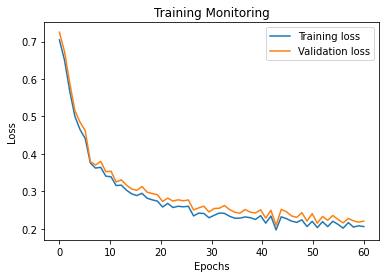

In [87]:
x = np.linspace(0,len(loss_tr),len(loss_tr))
y1, y2 = loss_tr, dev_loss
 
plt.plot(x, y1,label='Training loss')
plt.plot(x, y2, label='Validation loss')
 
plt.title('Training Monitoring')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend() 
plt.show()

In [88]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) for x,y in zip(test_indices_x,test_y)]

print('Accuracy:', accuracy_score(test_y,preds_te))
print('Precision:', precision_score(test_y,preds_te,average='macro'))
print('Recall:', recall_score(test_y,preds_te,average='macro'))
print('F1-Score:', f1_score(test_y,preds_te,average='macro'))

Accuracy: 0.7755555555555556
Precision: 0.7851723233255484
Recall: 0.7755555555555556
F1-Score: 0.7735548372159694


Using manual parameter, so the accuracy looks quite low

### Discuss how did you choose model hyperparameters ? 

In [89]:
# Firstly We should establish the list to select the parameters
from prettytable import PrettyTable
hdim_choice=[[200],[100,50],[200,50]]
lr_rate = [0.01,0.001,0.005]
dropout_rate = [0.2,0.4,0.5]
hyper_result = 0.0
test_result = 0.0
result = list()
hdim_his = []
lr_his = []
drop_his =[]

for hdim in range(len(hdim_choice)):
    for lr in range(len(lr_rate)):
        for drop in range(len(dropout_rate)):
            W = network_weights(vocab_size=len(train_voc_set),embedding_dim=300,hidden_dim=hdim_choice[hdim],num_classes=3)
            W[0] = w_glove
            W, loss_tr, dev_loss = SGD(train_indices_x, Y_tr=train_y, W=W, X_dev=dev_indices_x, Y_dev=dev_y, lr=lr_rate[lr], 
                            dropout=dropout_rate[drop],
                            freeze_emb=True,
                            tolerance=0.0001,
                            print_progress = False,
                            epochs=50)
            

            preds_dev = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) for x,y in zip(dev_indices_x,dev_y)]
            val_acc = accuracy_score(dev_y,preds_dev)
            hyper_result = val_acc
            
            hdim_his.append(hdim_choice[hdim])
            lr_his.append(lr_rate[lr])
            drop_his.append(dropout_rate[drop])
            result.append(hyper_result)
            ind = result.index(max(result))
            #print(hyper_result,dim_choice[dim],lr_rate[lr],dropout_rate[drop])
print(max(result),hdim_his[ind],lr_his[ind],drop_his[ind])


C:\Users\88690\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
C:\Users\88690\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' whe

C:\Users\88690\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
C:\Users\88690\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' whe

C:\Users\88690\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
C:\Users\88690\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' whe

0.8 [200, 50] 0.001 0.2


In [90]:
hidden_Table = PrettyTable(["Accuracy", "hdim", "lr_rate", "dropout_rate"])
for i in range(len(hdim_his)):
    hidden_Table.add_row([result[i],hdim_his[i],lr_his[i],drop_his[i]])
print(hidden_Table)

+---------------------+-----------+---------+--------------+
|       Accuracy      |    hdim   | lr_rate | dropout_rate |
+---------------------+-----------+---------+--------------+
|         0.7         |   [200]   |   0.01  |     0.2      |
|  0.7466666666666667 |   [200]   |   0.01  |     0.4      |
|  0.6666666666666666 |   [200]   |   0.01  |     0.5      |
|         0.78        |   [200]   |  0.001  |     0.2      |
|  0.7733333333333333 |   [200]   |  0.001  |     0.4      |
|         0.72        |   [200]   |  0.001  |     0.5      |
|  0.7066666666666667 |   [200]   |  0.005  |     0.2      |
|  0.7466666666666667 |   [200]   |  0.005  |     0.4      |
|  0.7066666666666667 |   [200]   |  0.005  |     0.5      |
|  0.6066666666666667 | [100, 50] |   0.01  |     0.2      |
|  0.5333333333333333 | [100, 50] |   0.01  |     0.4      |
| 0.38666666666666666 | [100, 50] |   0.01  |     0.5      |
|  0.7133333333333334 | [100, 50] |  0.001  |     0.2      |
|  0.6466666666666666 | 

In [91]:
#use best parameters to train model
W = network_weights(vocab_size=len(train_voc_set),embedding_dim=300,hidden_dim=hdim_his[ind], num_classes=3)

W[0] = w_glove

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

W, loss_tr, dev_loss = SGD(train_indices_x, Y_tr=train_y,
                            W=W,
                            X_dev=dev_indices_x, 
                            Y_dev=dev_y,
                            lr=lr_his[ind], 
                            dropout=drop_his[ind],
                            freeze_emb=True,
                            tolerance=0.0001,
                            epochs=50)

Shape W0 (8596, 300)
Shape W1 (300, 200)
Shape W2 (200, 50)
Shape W3 (50, 3)


C:\Users\88690\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch: 0 | Train loss: 0.37895976494673034 | Dev loss: 0.3628169281873837
Epoch: 1 | Train loss: 0.37284376220741977 | Dev loss: 0.3815940809867406
Epoch: 2 | Train loss: 0.2739563188162108 | Dev loss: 0.27261969406699116
Epoch: 3 | Train loss: 0.23212785043998332 | Dev loss: 0.23088439330928684
Epoch: 4 | Train loss: 0.2144193602935015 | Dev loss: 0.2186687675320238
Epoch: 5 | Train loss: 0.2537905021782272 | Dev loss: 0.2559530099014229
Epoch: 6 | Train loss: 0.15346836689504043 | Dev loss: 0.13776325648406978
Epoch: 7 | Train loss: 0.17572503527407127 | Dev loss: 0.18147120986297927
Epoch: 8 | Train loss: 0.19727352923979605 | Dev loss: 0.2050422648662519
Epoch: 9 | Train loss: 0.16965773135749676 | Dev loss: 0.1836730671351677
Epoch: 10 | Train loss: 0.18171920768485164 | Dev loss: 0.1901952428962639
Epoch: 11 | Train loss: 0.16365470531515208 | Dev loss: 0.1788001751407888
Epoch: 12 | Train loss: 0.20701117387358497 | Dev loss: 0.211011874485548
Epoch: 13 | Train loss: 0.184019841

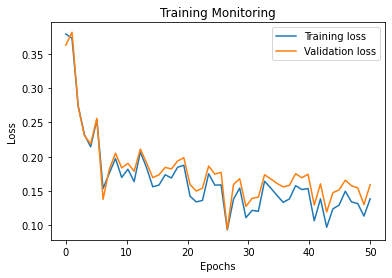

In [92]:
x = np.linspace(0,len(loss_tr),len(loss_tr))
y1, y2 = loss_tr, dev_loss
 
plt.plot(x, y1,label='Training loss')
plt.plot(x, y2, label='Validation loss')
 
plt.title('Training Monitoring')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend() 
plt.show()

In [93]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) 
            for x,y in zip(test_indices_x,test_y)]

print('Accuracy:', accuracy_score(test_y,preds_te))
print('Precision:', precision_score(test_y,preds_te,average='macro'))
print('Recall:', recall_score(test_y,preds_te,average='macro'))
print('F1-Score:', f1_score(test_y,preds_te,average='macro'))

Accuracy: 0.7977777777777778
Precision: 0.8099701165161451
Recall: 0.7977777777777778
F1-Score: 0.7950477027476411


## Full Results

Add your final results here:

| Model | Precision  | Recall  | F1-Score  | Accuracy
|:-:|:-:|:-:|:-:|:-:|
| Average Embedding  | 0.8588888888888889|  0.8619866910203213 | 0.8588888888888889| 0.8585911905628026   |
| Average Embedding (Pre-trained)  | 0.8866666666666667  | 0.887098394913521  |  0.8866666666666667 | 0.8868245713460235   |
| Average Embedding (Pre-trained) + X hidden layers    |0.7977777777777778  |  0.8099701165161451|   0.7977777777777778 |  0.7950477027476411 |


Please discuss why your best performing model is better than the rest.

The last model which is the one with pre-embedding and hidden layers is tge worst. The model with pre-trained embedding is better than average embedding according to the accuracy. For pre-trained embedding, we use tge GloVe model, this model could help to do co-courrence count.With hidden layers could consume more compuatation resources. I'll say at first, I didn't put the seed in the function, and the accuracy of the last model could reach 87.5%. However, once I put the seed in it, the accuracy always around 80%. This issue makes me confuse. I'll try to find out the reason in my future work.
